# Introduction

## Imports

In [58]:
import os,time
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch

from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

import numpy as np
import imageio 
import json
import torch.nn.functional as F
import cv2

from nerf_helper import *
# For repeatability
seed = 3407
torch.manual_seed(seed)
np.random.seed(seed)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [59]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.10.1


# Custom data processing (for Nerf)

In [60]:

trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w



In [61]:
x_rot = lambda theta: np.array([[1,0,0,0]
                               ,[0,np.cos(theta),-np.sin(theta),0]
                               ,[0,np.sin(theta),np.cos(theta),0]
                               ,[0,0,0,1]])

y_rot = lambda theta: np.array([[np.cos(theta),0,np.sin(theta),0]
                               ,[0,1,0,0]
                               ,[-np.sin(theta),0,np.cos(theta),0]
                               ,[0,0,0,1]])

z_rot = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0,0]
                               ,[np.sin(theta),np.cos(theta),0,0]
                               ,[0,0,1,0]
                               ,[0,0,0,1]])
arr2torch = lambda x : torch.from_numpy(x).to(device)

device

device(type='cuda')

In [62]:
def plot_viewdirs(viewdirs=None,view=(90,-90),color='blue',label='none'):

    vectors    = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in viewdirs])

    X = vectors[..., 0].flatten()
    Y = vectors[..., 1].flatten()
    Z = vectors[..., 2].flatten()

    origins = viewdirs[:, :3, -1]
    origin_X = origins[..., 0].flatten(),
    origin_Y = origins[..., 1].flatten(),
    origin_Z = origins[..., 2].flatten(),

    _ = ax.quiver(origin_X, origin_Y, origin_Z, X, Y, Z, length=1, color=color, normalize=True, label=label,alpha=0.4)
    
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.legend()
    plt.title('My camera poses')
    ax.view_init(view[0],view[1])


In [63]:
def load_data(tgt_class, json_path,resized_res=False):
    
    with open(json_path, 'r') as fp:
        meta = json.load(fp)

    imgs = []
    poses = []
    
    if 'colmap' in json_path:
        print('colmap_data')
        for frame in meta['frames']:
            img_fn = frame['file_path'].split('/')[-1]
            path = f'./dataset/data_square/{tgt_class}/{img_fn}'
            img = imageio.imread(path)
            imgs.append(img)
            poses.append(np.array(frame['transform_matrix']))

        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        camera_angle_x = float(meta['camera_angle_x'])
        camera_angle_y = float(meta['camera_angle_y'])
        H, W = imgs.shape[1:3]
        focal_x = .5 * W / np.tan(.5 * camera_angle_x)
        focal_y = .5 * H / np.tan(.5 * camera_angle_y)
    else:
        for data in meta['cameras']:
            i = data['cameraId']
            zfiil_n = str(i).zfill(2)
            img_fn = 'image_view{}.png'.format(zfiil_n)
            path = f'./dataset/data_square/{tgt_class}/{img_fn}'
            imgs.append(imageio.imread(path))
            rt_mat = meta['cameras'][i]['extrinsic']['RT_matrix']
            rt_mat = np.asarray(list(rt_mat.values())).reshape([4,4])
            poses.append(rt_mat)
        
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        camera_angle_x = meta['cameras'][0]['intrinsic']['x_focalLength_inPixels']
        camera_angle_y = meta['cameras'][0]['intrinsic']['y_focalLength_inPixels']
        H, W = imgs.shape[1:3]
        focal_x = camera_angle_x
        focal_y = camera_angle_y

    if resized_res:
        
        print(resized_res,':',H,W,focal_x, focal_y,'-->',H//resized_res,W//resized_res,focal_x/resized_res,focal_y/resized_res)

        H = H//resized_res
        W = W//resized_res
        focal_x = focal_x/resized_res
        focal_y = focal_y/resized_res
        imgs_reszed_res = np.zeros((imgs.shape[0], H, W, 3))
        for i, img in enumerate(imgs):
            imgs_reszed_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_reszed_res

    data = {'images':imgs, 'poses':poses, 'focal_x':np.array(focal_x), 'focal_y':np.array(focal_y)}
    
    print(f'Images shape: {imgs.shape}',f'Poses shape: {poses.shape}',f'Focal_x: {focal_x}',f'Focal_y: {focal_y}')

    return data


In [64]:
tgt_class = '2-16-2_24_leather-white-wood-3+-seater-recliner_5_5_1_polygon'
# tgt_class = '2-21-2_7_retro-style-mint-oven_3_3_1_polygon'

colmap_data = load_data(tgt_class,json_path='./dataset/colmap_poses.json',resized_res=8) 

d2r_data    = load_data(tgt_class,json_path='./dataset/cameras.json',resized_res=8)

colmap_data
8 : 1080 1080 2073.3593593936484 2073.3593593936484 --> 135 135 259.16991992420606 259.16991992420606
Images shape: (21, 135, 135, 3) Poses shape: (21, 4, 4) Focal_x: 259.16991992420606 Focal_y: 259.16991992420606
8 : 1080 1080 1544.0450439453125 1158.03369140625 --> 135 135 193.00563049316406 144.75421142578125
Images shape: (24, 135, 135, 3) Poses shape: (24, 4, 4) Focal_x: 193.00563049316406 Focal_y: 144.75421142578125


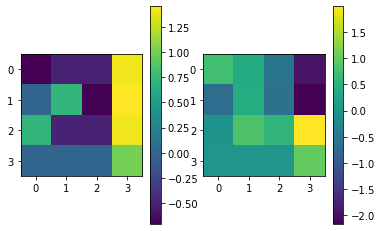

In [65]:
plt.subplot(1,2,1)
plt.imshow(d2r_data['poses'][0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(colmap_data['poses'][0])
plt.colorbar()

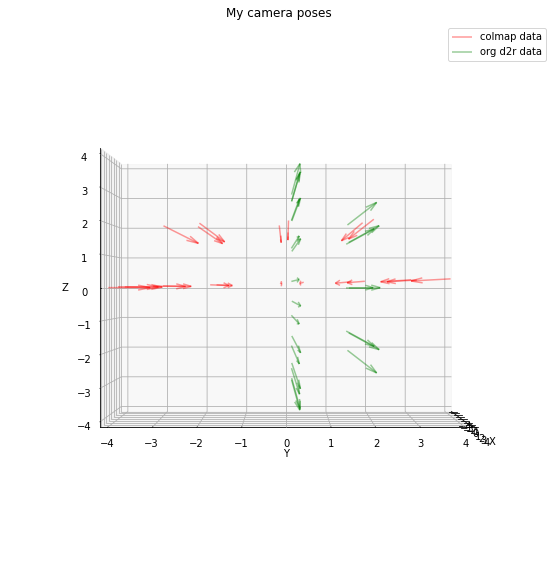

In [66]:
#rot_2 = np.array([z_rot(np.pi/).dot(pose) for pose in d2r_data['poses']]) 


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plot_viewdirs(viewdirs=colmap_data['poses'][:],view=(0,0),color='red', label='colmap data')
plot_viewdirs(viewdirs= d2r_data['poses'][:],view=(0,0),color='green',label='org d2r data')


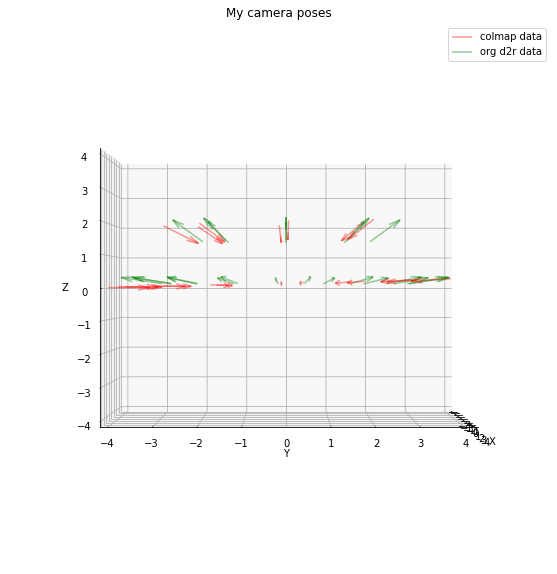

In [67]:

rot_poses = np.array([x_rot(np.pi/2).dot(pose) for pose in d2r_data['poses']]) # for 90° Rotation in x-axis
# rot_poses[:,:3,:3] = np.asarray([(-pose[:3,:3]) for pose in rot_poses],dtype=np.float32)# 노말 방향 반대로 변환 함.
# tmp = rot_poses[:, 1:2, 2:].copy()
# rot_poses[:, 1:2, 2:] = -rot_poses[:, 2:3, 2:]
# rot_poses[:, 2:3, 2:] = -tmp

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plot_viewdirs(viewdirs= colmap_data['poses'][:],view=(0,0),color='red', label='colmap data')
plot_viewdirs(viewdirs= rot_poses[:],view=(0,0),color='green',label='org d2r data')

In [68]:
import pdb
import torch
import numpy as np

class Pose():
    """
    A class of operations on camera poses (PyTorch tensors with shape [...,3,4])
    each [3,4] camera pose takes the form of [R|t]
    """

    def __call__(self,R=None,t=None):
        # construct a camera pose from the given R and/or t
        assert(R is not None or t is not None)
        if R is None:
            if not isinstance(t,torch.Tensor): t = torch.tensor(t)
            R = torch.eye(3,device=t.device).repeat(*t.shape[:-1],1,1)
        elif t is None:
            if not isinstance(R,torch.Tensor): R = torch.tensor(R)
            t = torch.zeros(R.shape[:-1],device=R.device)
        else:
            if not isinstance(R,torch.Tensor): R = torch.tensor(R)
            if not isinstance(t,torch.Tensor): t = torch.tensor(t)
        assert(R.shape[:-1]==t.shape and R.shape[-2:]==(3,3))
        R = R.float()
        t = t.float()
        pose = torch.cat([R,t[...,None]],dim=-1) # [...,3,4]
        assert(pose.shape[-2:]==(3,4))
        return pose

    def invert(self,pose,use_inverse=False):
        # invert a camera pose
        R,t = pose[...,:3],pose[...,3:]
        R_inv = R.inverse() if use_inverse else R.transpose(-1,-2)
        t_inv = (-R_inv@t)[...,0]
        pose_inv = self(R=R_inv,t=t_inv)
        return pose_inv

    def compose(self,pose_list):
        # compose a sequence of poses together
        # pose_new(x) = poseN o ... o pose2 o pose1(x)
        pose_new = pose_list[0]
        for pose in pose_list[1:]:
            pose_new = self.compose_pair(pose_new,pose)
        return pose_new

    def compose_pair(self,pose_a,pose_b):
        # pose_new(x) = pose_b o pose_a(x)
        R_a,t_a = pose_a[...,:3].to(device).float(),pose_a[...,3:].to(device).float()
        #R_a,t_a = arr2torch(R_a), arr2torch(t_a)
        
        R_b,t_b = pose_b[...,:3].to(device).float(),pose_b[...,3:].to(device).float()
        #R_b,t_b = arr2torch(R_b), arr2torch(t_b)        
        
        R_new = R_b.to(device).float()@R_a.to(device).float()
        t_new = (R_b@t_a+t_b).to(device).float()
        t_new = t_new[...,0]
        pose_new = self(R=R_new,t=t_new)
        return pose_new

camera = Pose()
new_poses = []
for pose_raw in rot_poses:
    pose_raw = arr2torch(pose_raw[:3, :4])
    pose_flip = camera(R=torch.diag(torch.tensor([1,1,-1])))
    pose = camera.compose([pose_flip,pose_raw[:3]])
    new_poses.append(pose)
    
new_poses = torch.stack(new_poses)
new_poses = np.array(new_poses.detach().cpu())
new_poses[:, 0] *= -1
# new_poses[:, :3, 1] *= -1
# new_poses[:, 2, 0] *= -1

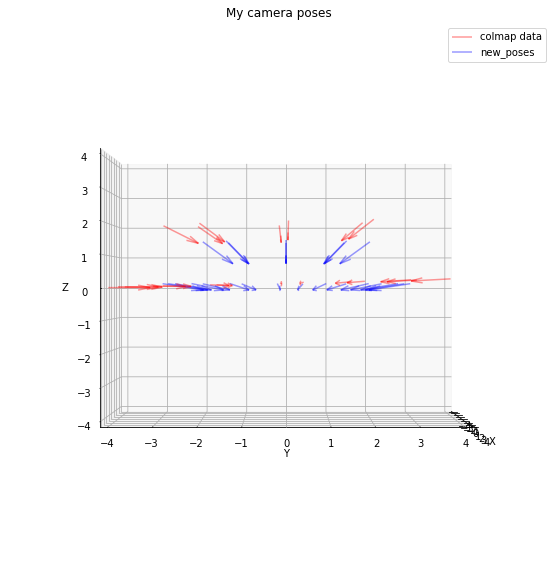

In [69]:
i = 0
j = 0
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plot_viewdirs(viewdirs=colmap_data['poses'][:],view=(i,j),color='red', label='colmap data')
plot_viewdirs(viewdirs=np.array(new_poses)[:],view=(i,j),color='blue',label='new_poses')


# Train

## Hyperparameters


In [70]:
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 11000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = False          # Crop the center of image (one_image_per_)
center_crop_iters = 64      # Stop cropping center after this many epochs
display_rate = 100         # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
l3 = 11.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {'n_samples': n_samples
                            ,'perturb': perturb
                            ,'inverse_depth': inverse_depth}

kwargs_sample_hierarchical = {'perturb': perturb}

## Training Classes and Functions

## Training Loop

In [71]:
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    all_rays = torch.stack([torch.stack(get_rays(height, width, focal_x, focal_y, p), 0)
                        for p in poses[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      trn_idxes = np.arange(trn_idx+1)
      np.random.shuffle(trn_idxes)
      target_img_idx = trn_idxes[0]
      target_img = images[target_img_idx].to(device)
      if center_crop and i < center_crop_iters:
        target_img = crop_center(target_img)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      rays_o, rays_d = get_rays(height, width, focal_x, focal_y, target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)
    
    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']

    loss = torch.nn.functional.mse_loss(rgb_predicted.float(), target_img.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Compute mean-squared error between predicted and target images.
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = images[tst_idx].shape[:2]
      rays_o, rays_d = get_rays(height, width, focal_x, focal_y, poses[tst_idx])
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted, depth_predicted = outputs['rgb_map'], outputs['depth_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, images[tst_idx].reshape(-1, 3))
      
      val_psnr = -10. * torch.log10(loss)
      
      val_psnrs.append(val_psnr.item())
      print("Loss:", loss.item(), "train_psnr:", psnr.item(), "val_psnr:", val_psnr.item())
      iternums.append(i)

      # Plot example outputs   
      fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
      
      ax[0].imshow(images[tst_idx].detach().cpu().numpy())
      ax[0].set_title(f'iter. : {i} | Target')
    
      ax[1].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      ax[1].set_title(f'predicted rgb')
      
      ax[2].imshow(depth_predicted.reshape([height,width]).detach().cpu().numpy())
      ax[2].set_title('predicted depth')
        
      
      ax[3].plot(range(0, i + 1), train_psnrs, 'r',label='train')
      ax[3].plot(iternums, val_psnrs, 'b',label='valid')
      ax[3].legend()
        
      ax[3].set_title('PSNR {:.2}'.format(val_psnrs[-1]))
      '''
      z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      
      if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      
      else:
        z_sample_hierarch = None
      _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[4])
      
      ax[4].margins(0)'''
      plt.savefig(img_savedir+f'result_{i}.png')
      plt.show(block=False)
      plt.close()
    
        
    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs
        

  return True, train_psnrs, val_psnrs

In [72]:
def init_models():
        
    # Encoders
    encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
    encode = lambda x: encoder(x)

    # View direction encoders
    if use_viewdirs:
        encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,log_space=log_space)
        encode_viewdirs = lambda x: encoder_viewdirs(x)
        d_viewdirs = encoder_viewdirs.d_output
    else:
        encode_viewdirs = None
        d_viewdirs = None

    # Models
    model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,d_viewdirs=d_viewdirs)
    model.to(device)
    model_params = list(model.parameters())
    if use_fine_model:
        fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                          d_viewdirs=d_viewdirs)
        fine_model.to(device)
        model_params = model_params + list(fine_model.parameters())
    else:
        fine_model = None

    # Optimizer
    optimizer = torch.optim.Adam(model_params, lr=np.float32(lr))

    # Early Stopping
    warmup_stopper = EarlyStopping(patience=50)

    return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper


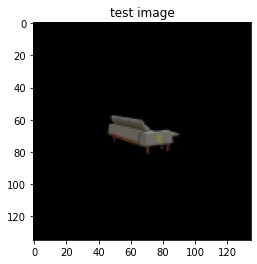

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss: 0.06220807135105133 train_psnr: 10.851473808288574 val_psnr: 12.061532974243164


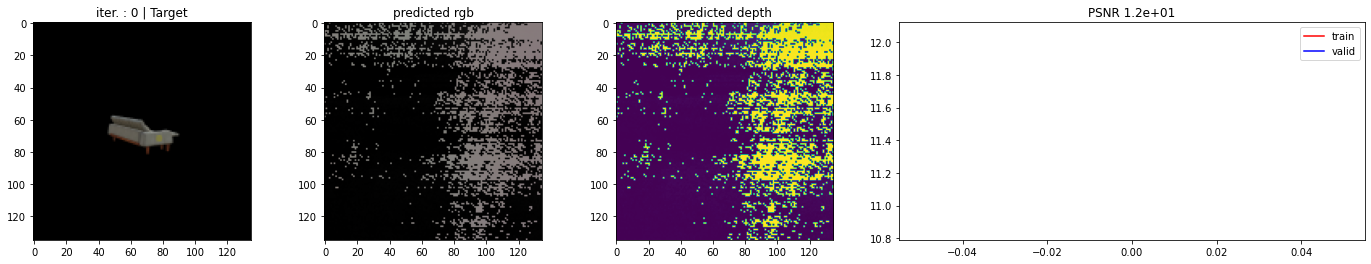

  3%|▎         | 163/5000 [00:43<21:43,  3.71it/s]


KeyboardInterrupt: 

In [74]:
# Gather as torch tensors
warmup_min_fitness = 10
tgt_class = tgt_class

# d2r_data['poses'] = rot_poses
d2r_data['poses'] = new_poses

data = d2r_data
# data = colmap_data

images_arr = data['images'][:,:,:,:3]
poses_arr = data['poses']
focal_arr_x = data['focal_x']
focal_arr_y = data['focal_y']

height, width = images_arr.shape[1:3]
near, far = 2., 6.

# trn_idx = 21
# tst_idx = 22
trn_idx = images_arr.shape[0] - 3  # -3 ? why?
tst_idx = images_arr.shape[0] - 2


images = torch.from_numpy(images_arr).to(device).float()
poses = torch.from_numpy(poses_arr).to(device).float()
focal_x = torch.from_numpy(focal_arr_x).to(device).float()
focal_y = torch.from_numpy(focal_arr_y).to(device).float()

plt.title('test image')
plt.imshow(images_arr[tst_idx])
plt.show()

savedir = './logs/'
os.makedirs(savedir,exist_ok=True)

img_savedir = savedir+'result_imgs/{}/'.format(tgt_class)
os.makedirs(img_savedir,exist_ok=True)

display_rate = 200
# Run training session(s)
n_iters = 5000

training = True
if training == True:
    for _ in range(10000):
        start = time.time()
        model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
        success, train_psnrs, val_psnrs = train()

        if success and val_psnrs[-1] >= warmup_min_fitness:

            print('Training successful!')
            path = os.path.join(savedir, '{}_model.tar'.format(tgt_class))
            torch.save({'model':model,'fine_model':fine_model}, path)
            print('Saved checkpoints at', path)
            end = time.time()

            cost_time = (end - start) 
            h,m,s = cost_time//(60*60),(cost_time%(60*60))//60, (cost_time%(60*60))%60 
            print('{:.4} hour {:.4} min {:.4} sec'.format(h,m,s))
            break
    print('')
    print(f'Done!')

In [ ]:
def rendering(tgt_class):
    
    ckpt = torch.load('./logs/{}_model.tar'.format(tgt_class))

    model, fine_model = ckpt['model'], ckpt['fine_model']

    frames = []
    poses = [] 

    for th in np.linspace(0., 360., 100, endpoint=False):
        c2w = pose_spherical(th, -20., 3.5).to("cuda") 
        poses.append(c2w.detach().cpu().numpy())
        rays_o, rays_d = get_rays(height, width, focal_x, focal_y, c2w)
        rays_o = rays_o.reshape([-1, 3])
        rays_d = rays_d.reshape([-1, 3])

        outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=2**15)
        rgb = outputs['rgb_map']
        rgb = rgb.reshape([height, width, 3]).detach().cpu().numpy()
        img = (255*np.clip(rgb,0,1)).astype(np.uint8)
        frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

    f = './logs/{}_video.gif'.format(tgt_class)
    imageio.mimwrite(f, frames, fps=30)

In [ ]:
# rendering
rendering(tgt_class)

In [ ]:
# testing

In [ ]:
from skimage.metrics import structural_similarity as ssim 
import argparse
import cv2
from skimage import io

def mtjin_bgr2gray(bgr_img):
    # BGR 색상값
    b = bgr_img[:, :, 0]*255
    g = bgr_img[:, :, 1]*255
    r = bgr_img[:, :, 2]*255
    result = ((0.299 * r) + (0.587 * g) + (0.114 * b))
    # imshow 는 CV_8UC3 이나 CV_8UC1 형식을 위한 함수이므로 타입변환
    return result.astype(np.uint8)

def testing(tgt_class):
    psnrs = []
    ssims = []
    
    ckpt = torch.load('./logs/{}_model.tar'.format(tgt_class))
    model, fine_model = ckpt['model'], ckpt['fine_model']
    data = load_data(tgt_class,json_path='./dataset/cameras.json',resized_res=5)

    for idx,ds_name in zip(range(22,24),['ValSet','TestSet']):

        pose = poses[idx]
        rays_o, rays_d = get_rays(height, width, focal_x, focal_y, pose)
        rays_o = rays_o.reshape([-1, 3])
        rays_d = rays_d.reshape([-1, 3])

        outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=2**15)

        imageA = outputs['rgb_map']#.astype(np.uint8)
        imageA = imageA.reshape([height, width, 3]).detach().cpu().numpy()
        imageB = images[idx]#.astype(np.uint8)
        imageB = imageB.detach().cpu().numpy()
        imageB = np.array(imageB, dtype=np.float32)

        plt.suptitle(ds_name,y=0.85)
        plt.subplot(1,2,1)
        plt.title('pred_rgb')
        plt.imshow(imageA)
        plt.subplot(1,2,2)
        plt.title('true_rgb')
        plt.imshow(imageB)
        plt.show()

        # 4. Convert the images to grayscale
        grayA =  mtjin_bgr2gray(imageA)
        grayB =  mtjin_bgr2gray(imageB)

        # 5. Compute the Structural Similarity Index (SSIM) between the two
        #    images, ensuring that the difference image is returned
        (score, diff) = ssim(grayA, grayB, full=True)
        diff = (diff * 255).astype("uint8")
        ssims.append(score)


        imageA = outputs['rgb_map']#.astype(np.uint8)
        imageA = imageA.reshape([height, width, 3])
        imageB = images[idx]#.astype(np.uint8)

        loss = torch.nn.functional.mse_loss(imageA.reshape(-1, 3), imageB.reshape(-1, 3))
        psnr = -10. * torch.log10(loss)
        psnrs.append(psnr.item())

        print('ds_name : {} psnr : {:.4} ssim : {:.4}'.format(ds_name, psnr,score))


5 : 1080 1080 1544.0450439453125 1158.03369140625 --> 216 216 308.8090087890625 231.60673828125
Images shape: (24, 216, 216, 3) Poses shape: (24, 4, 4) Focal_x: 308.8090087890625 Focal_y: 231.60673828125


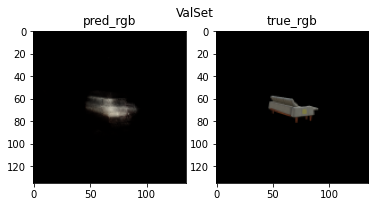

ds_name : ValSet psnr : 30.17 ssim : 0.959


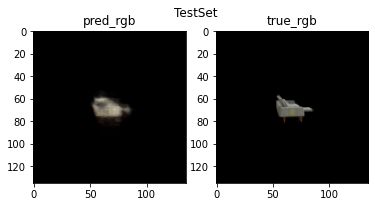

ds_name : TestSet psnr : 30.37 ssim : 0.9627


In [ ]:
testing(tgt_class)